In [1]:
import os
import sys
import string
import pickle
import numpy as np
import xarray as xr
import cmocean
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt

In [2]:
sys.path.append('..')
matplotlib.rc_file('../rc_file_paper')
%load_ext autoreload
%autoreload 2

In [3]:
from maps import rect_polygon
from paths import file_HadISST, path_prace, path_results
from filters import lowpass
from regions import mask_box_in_region, SST_index_bounds
from xr_DataArrays import xr_AREA
from ab_derivation_SST import DeriveSST as DS
from bd_analysis_indices import AnalyzeIndex as AI
from bb_analysis_timeseries import AnalyzeTimeSeries as ATS


The file "/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f09_g16/spinup_pd_maxcores_f09_g16/run/spinup_pd_maxcores_f09_g16.cam2.h0.0001-01.nc" does not exist


## HadISST

In [4]:
# ds = xr.open_dataset(file_HadISST)
# dhm = xr.open_dataarray(f'{path_prace}/SST/SST_monthly_had.nc', decode_times=False)
dhy = xr.open_dataarray(f'{path_prace}/SST/SST_yrly_had.nc', decode_times=False)

In [5]:
# # create yearly COBE data
dc = xr.open_dataarray('../../data/COBE/sst.mon.mean.nc')
dc = dc.sel(time=slice('1870-01-01','2018-12-01'))
# dc_ = dc.groupby('time.year').mean('time').rename({'year':'time'})
# dc_.to_netcdf(f'{path_prace}/SST/SST_yrly_cobe.nc')
dc = dc.fillna(np.nan).to_netcdf(f'{path_prace}/SST/SST_monthly_cobe.nc')

In [6]:
# # create yrly ERSST
# de = xr.open_mfdataset('../../data/ersst/ersst.v5.*.nc', concat_dim='time', combine='nested')#.ssta
# de['date'] = ('time', xr.cftime_range(start='1854-01-01',end='2020-12-01', freq='MS'))
# de = de.set_index({'time':'date'}).ssta.sel(time=slice('1870-01-01','2018-12-01'))
# de_ = de.groupby('time.year').mean('time').rename({'year':'time'})
# de_.to_netcdf(f'{path_prace}/SST/SST_yrly_ersst.nc')
# de.to_netcdf(f'{path_prace}/SST/SST_monthly_ersst.nc')

In [7]:
# # inconsistent time stamp
# de = xr.open_mfdataset('../../data/ersst/ersst.v5.*.nc', concat_dim='time', combine='nested')
# with np.printoptions(threshold=np.inf):
#     print(de.time.values[:])

In [8]:
dcm = xr.open_dataarray(f'{path_prace}/SST/SST_monthly_cobe.nc')
# dcm = xr.open_dataarray(f'{path_prace}/SST/SST_monthly_ds_dt_cobe.nc')
dcy = xr.open_dataarray(f'{path_prace}/SST/SST_yrly_cobe.nc')
dem = xr.open_dataarray(f'{path_prace}/SST/SST_monthly_ersst.nc')
# dem = xr.open_dataarray(f'{path_prace}/SST/SST_monthly_ds_dt_ersst.nc')
dey = xr.open_dataarray(f'{path_prace}/SST/SST_yrly_ersst.nc')

In [9]:
rn = {'latitude':'lat', 'longitude':'lon'}
RMASK_cobe = xr.open_dataarray(f'{path_prace}/grid/RMASK_ocn_cobe.nc').rename(rn)
RMASK_ersst = xr.open_dataarray(f'{path_prace}/grid/RMASK_ocn_ersst.nc').rename(rn)
RMASK_had = xr.open_dataarray(f'{path_prace}/grid/RMASK_ocn_had.nc')
AREA_cobe = xr_AREA('ocn_cobe').rename(rn)
AREA_ersst = xr_AREA('ocn_ersst').rename(rn)
AREA_had = xr_AREA('ocn_had')


### AMO

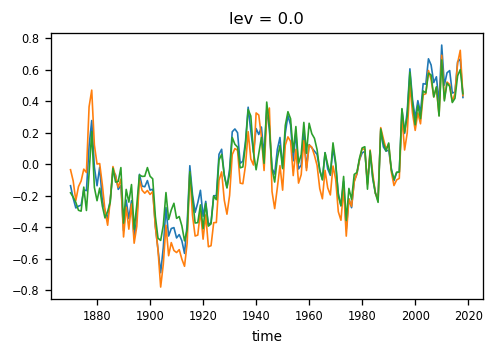

In [10]:
AMO_sel_c = {'lon':slice(360-80,360), 'lat':slice(60,0)}
AMO_sel_e = {'lon':slice(360-80,360), 'lat':slice(0,60)}
AMO_sel_h = {'longitude':slice(-80,0), 'latitude':slice(60,0)}
AMO_c = dcy.sel(AMO_sel_c).where(RMASK_cobe ==6).weighted(AREA_cobe .sel(AMO_sel_c)).mean(['lat','lon'])
AMO_e = dey.sel(AMO_sel_e).where(RMASK_ersst==6).weighted(AREA_ersst.sel(AMO_sel_e)).mean(['lat','lon'])
AMO_h = dhy.sel(AMO_sel_h).where(RMASK_had  ==6).weighted(AREA_had  .sel(AMO_sel_h)).mean(['latitude','longitude'])
(AMO_c-AMO_c.mean()).plot()
AMO_e.plot()
plt.plot(AMO_h.time/365+1870,(AMO_h-AMO_h.mean()))


In [11]:
# for Iris
AMO_c.to_netcdf(f'{path_prace}/SST/AMO_raw_cobe.nc')
AMO_e.to_netcdf(f'{path_prace}/SST/AMO_raw_ersst.nc')
AMO_h.to_netcdf(f'{path_prace}/SST/AMO_raw_had.nc')

In [13]:
lowpass(xr.open_dataarray(f'{path_prace}/SST/AMO_ds_dt_raw_cobe.nc' ), 12*13).to_netcdf(f'{path_prace}/SST/AMO_ds_dt_low13y_cobe.nc')
lowpass(xr.open_dataarray(f'{path_prace}/SST/AMO_ds_dt_raw_ersst.nc'), 12*13).to_netcdf(f'{path_prace}/SST/AMO_ds_dt_low13y_ersst.nc')
lowpass(xr.open_dataarray(f'{path_prace}/SST/AMO_ds_dt_raw_had.nc'  ), 12*13).to_netcdf(f'{path_prace}/SST/AMO_ds_dt_low13y_had.nc')


### SOM

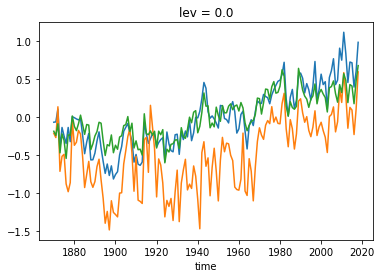

In [12]:
SOM_sel_c = {'lon':slice(360-50,360), 'lat':slice(-35,-50)}
SOM_sel_e = {'lon':slice(360-50,360), 'lat':slice(-50,-35)}
SOM_sel_h = {'longitude':slice(-50,0), 'latitude':slice(-35,-50)}
SOM_c = dcy.where(RMASK_cobe ==1).sel(SOM_sel_c).weighted(AREA_cobe .sel(SOM_sel_c)).mean(['lat','lon'])
SOM_e = dey.where(RMASK_ersst==1).sel(SOM_sel_e).weighted(AREA_ersst.sel(SOM_sel_e)).mean(['lat','lon'])
SOM_h = dhy.where(RMASK_had  ==1).sel(SOM_sel_h).weighted(AREA_had  .sel(SOM_sel_h)).mean(['latitude','longitude'])
(SOM_c-SOM_c.mean()).plot()
SOM_e.plot()
plt.plot(SOM_h.time/365+1870,(SOM_h-SOM_h.mean()))


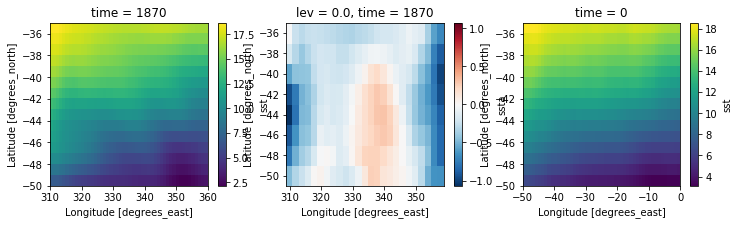

In [14]:
f, ax = plt.subplots(1,3, figsize=(12,3))
dcy.where(RMASK_cobe ==1).sel(SOM_sel_c).isel(time=0).plot(ax=ax[0])
dey.where(RMASK_ersst==1).sel(SOM_sel_e).isel(time=0).plot(ax=ax[1])
dhy.where(RMASK_had  ==1).sel(SOM_sel_h).isel(time=0).plot(ax=ax[2])

### PDO

In [14]:
# PDO_sel_c = {'lon':slice(110,255), 'lat':slice(68,20)}
# PDO_sel_e = {'lon':slice(110,255), 'lat':slice(20,68)}
# AREA_cobe .where(RMASK_cobe ==2).sel(PDO_sel_c).to_netcdf(f'{path_prace}/geometry/AREA_20N_ocn_cobe.nc')
# AREA_ersst.where(RMASK_ersst==2).sel(PDO_sel_e).to_netcdf(f'{path_prace}/geometry/AREA_20N_ocn_ersst.nc')
# dcm.where(RMASK_cobe ==2).sel(PDO_sel_c).to_netcdf(f'{path_prace}/SST/SST_monthly_20N_cobe.nc' )
# dem.where(RMASK_ersst==2).sel(PDO_sel_e).to_netcdf(f'{path_prace}/SST/SST_monthly_20N_ersst.nc')

In [9]:
# # deseasonalize and detrend COBE and ERSST
# DS().deseasonalize_monthly_data('cobe')
# DS().detrend_monthly_obs_two_factor('cobe') # 3:35 min
# DS().deseasonalize_monthly_data('ersst')
# DS().detrend_monthly_obs_two_factor('ersst')  # 0:53 min
# # works!

In [ ]:
# for run in ['cobe','ersst']:
#     AI().Pacific_EOF_analysis(run=run, extent='20N')  # works
#     AI().derive_autocorrelation_maps(run=run, tavg='monthly')
#     for j, idx in enumerate(['AMO', 'SOM', 'PMV']):
#         if idx=='PMV':
#             fn = f'{path_prace}/SST/{idx}_20N_regr_{run}.nc'
#         else:
#             fn = f'{path_prace}/SST/{idx}_regr_{run}.nc'
#         print(run, idx)
#         index = AI().derive_SST_avg_index(run=run, index=idx)  # works
#         AI().make_regression_files(run=run, idx=idx, time=None)
#         plt.plot(index+j)

## Maps

In [21]:
fn_dict = f'{path_results}/MV-paper/idx_spectra.pkl'
if os.path.exists(fn_dict):
# if os.path.exists(fn_dict)==False:  # to force creation
    spec_dict_unfilt = pickle.load(open(fn_dict, 'rb'))

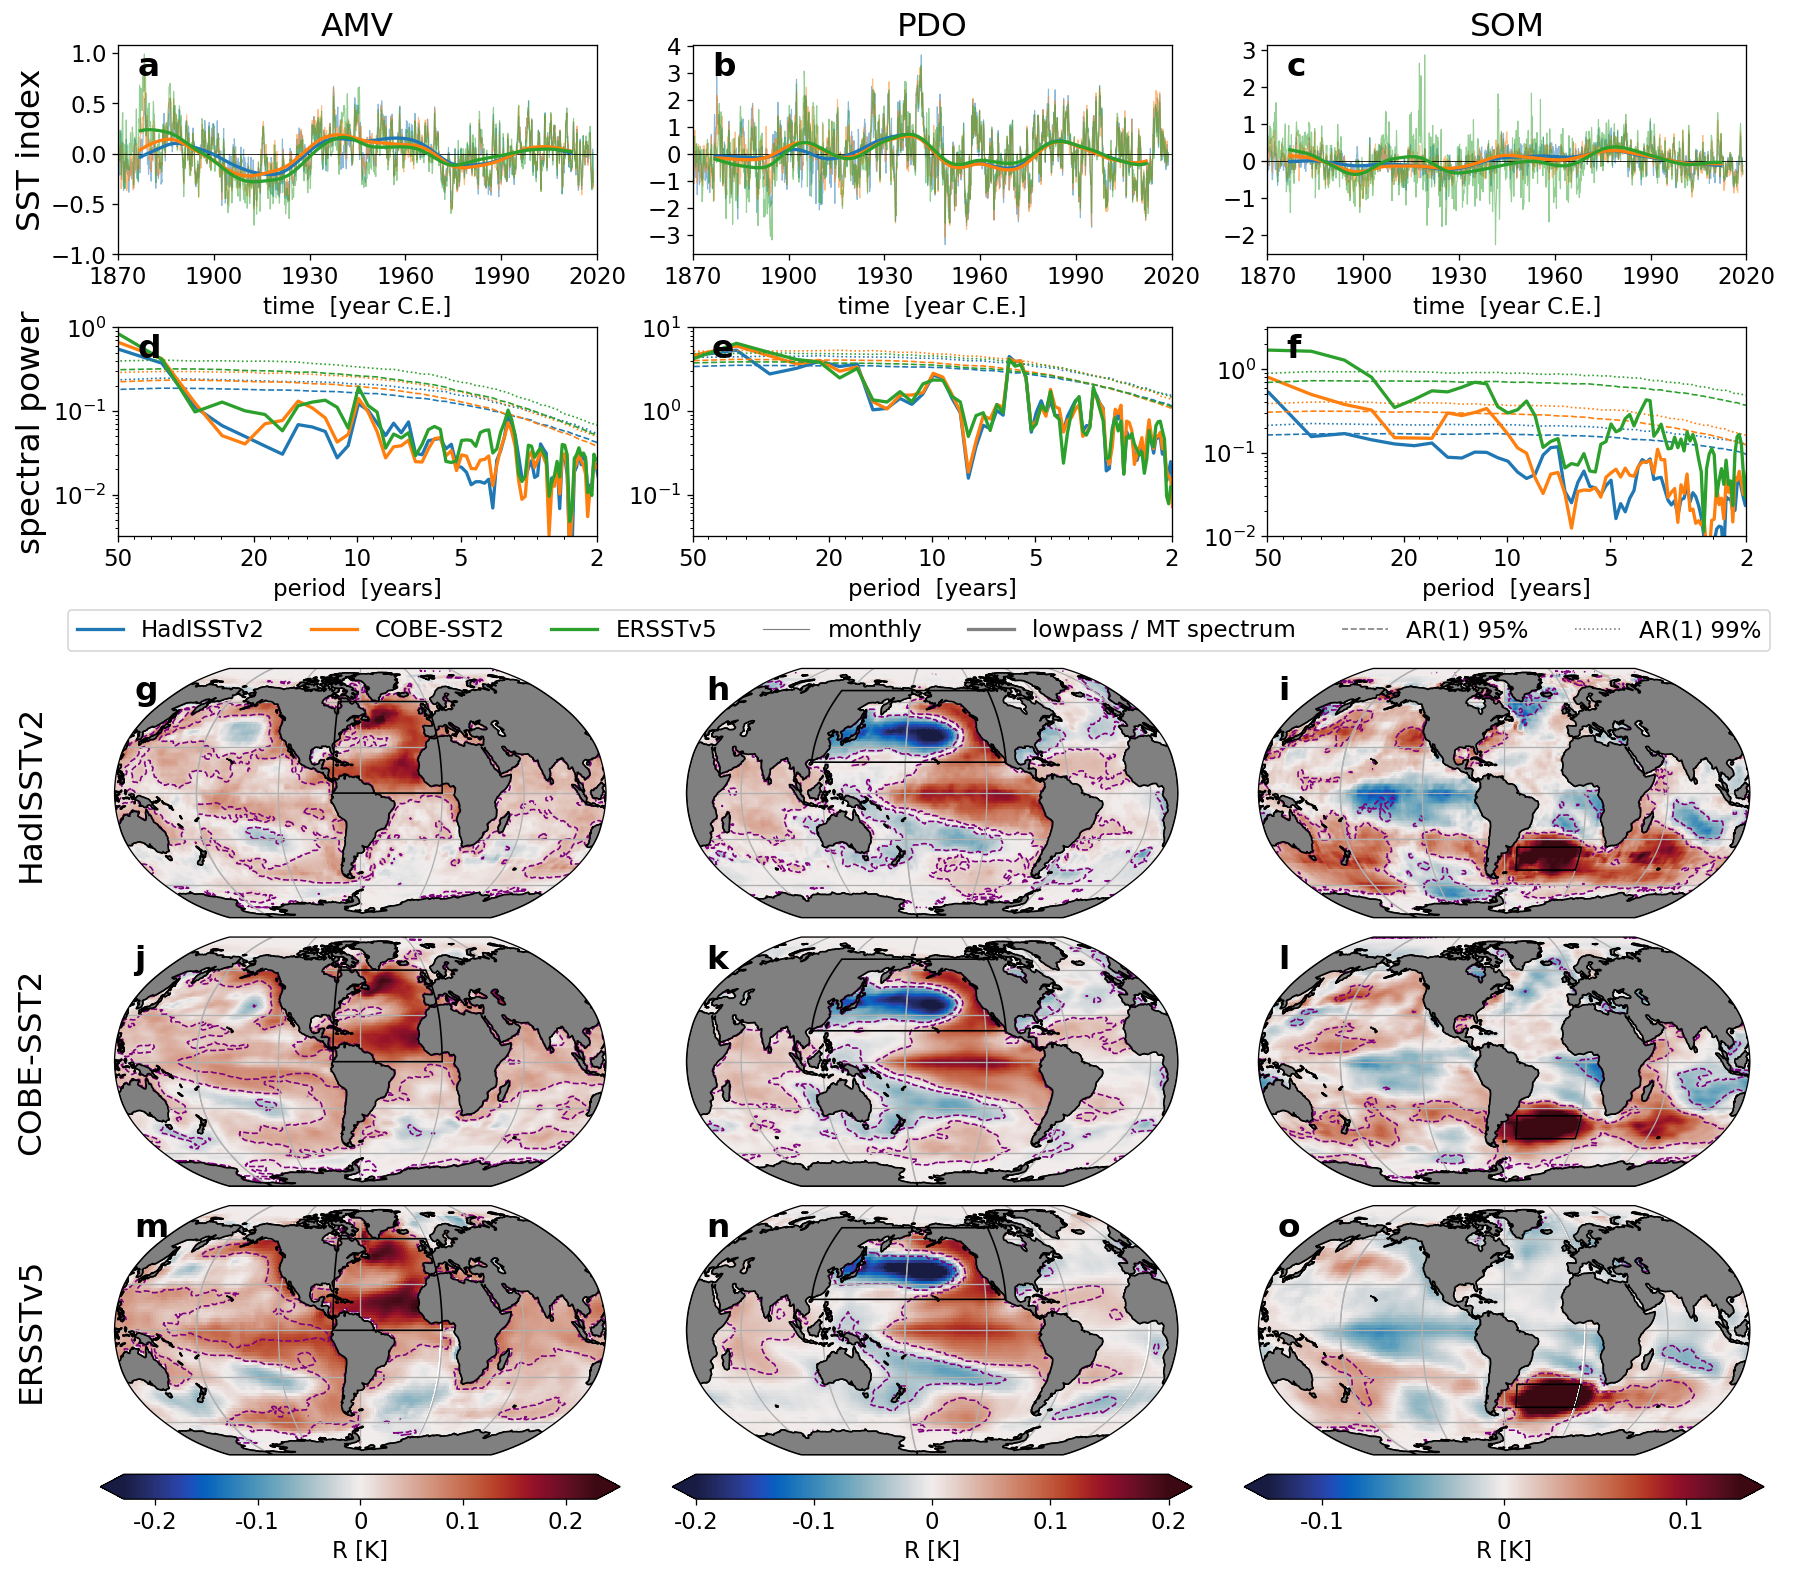

In [49]:
time = np.arange(1870,2019,1/12)
xticks = [50,20,10,5,2]
ticks = [-.3,-.2,-.1,0,.1,.2,.3]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)

f = plt.figure(figsize=(15,16))
gs0 = f.add_gridspec(2, 1, left=0   , right=.04, bottom=.62                        , hspace=.35)
gs1 = f.add_gridspec(2, 3, left=0.06, right=.98, bottom=.62                        , hspace=.35)
gs2 = f.add_gridspec(4, 3, left=0.05, right=.99, top=.55,  height_ratios=[1,1,1,.1], hspace=0.1, wspace=0.1)
gs3 = f.add_gridspec(4, 1, left=0   , right=.04, top=.55,  height_ratios=[1,1,1,.1], hspace=0.1)

axl = f.add_axes([.06,.56,.94,.02])
axl.axis('off')

for j, idx in enumerate(['AMO','PDO','SOM']):
    label_ = ['HadISSTv2', 'COBE-SST2', 'ERSSTv5'][j]
    ax = f.add_subplot(gs3[j])
    ax.axis('off')
    axl.plot([],[], c=f'C{j}', lw=2, label=label_)
    ax.text(.5, .5, label_, transform=ax.transAxes, rotation='vertical', va='center', ha='right', fontsize=20)
    maxv = [.23, .2, .13][j]
    rect = rect_polygon(SST_index_bounds(idx))
    for i, run in enumerate(['had','cobe','ersst']):

        # data
        if run=='had':  pf = 1
        else:           pf = -1
            
        if idx=='PDO':
            index = xr.open_dataset(f'{path_prace}/SST/PMV_EOF_20N_{run}.nc', decode_times=False).pcs.isel(mode=0)*pf
            std = lowpass(index, 12*13).std().values
            xa = xr.open_dataset(f'{path_prace}/SST/PMV_20N_regr_{run}.nc')
            spec = spec_dict_unfilt[f'PMV_EOF_20N_{run}_spec']
            rnnh = spec_dict_unfilt[f'PMV_EOF_20N_{run}_rnnh']
            xa['slope'] *= pf
        else:
            index = xr.open_dataarray(f'{path_prace}/SST/{idx}_ds_dt_raw_{run}.nc', decode_times=False)
            std = lowpass(index, 12*13).std().values
            xa = xr.open_dataset(f'{path_prace}/SST/{idx}_regr_{run}.nc')
            spec = spec_dict_unfilt[f'{idx}_{run}_spec']
            rnnh = spec_dict_unfilt[f'{idx}_{run}_rnnh']
        lats, lons = xa.latitude, xa.longitude
        lons, lats = np.meshgrid(lons, lats)
        
        # time series & spectra
        if i==0:
            ax_ts = f.add_subplot(gs1[0,j])
            ax_ts.set_xticks(np.arange(1870,2021,30))
            ax_ts.set_xlim((1870,2020))
            ax_ts.set_xlabel('time  [year C.E.]', fontsize=14)
            ax_ts.set_title(['AMV','PDO','SOM'][j], fontsize=20)
            ax_ts.axhline(0, c='k', lw=.5)
            ax_sp = f.add_subplot(gs1[1,j])
            ax_sp.set_xlabel('period  [years]')
            
        ax_ts.plot(time            , index                           , c=f'C{i}', lw=0.7, alpha=.5, zorder=1)
        ax_ts.plot(time[7*12:-7*12], lowpass(index,12*13)[7*12:-7*12], c=f'C{i}', lw=2, label=run, zorder=2)
    
        ax_sp.plot(spec[1]*12, spec[0]/12, lw=2)
        ax_sp.plot(rnnh['freq']*12, rnnh['95']/12, c=f'C{i}', ls='--', label='AR(1) 95%')
        ax_sp.plot(rnnh['freq']*12, rnnh['99']/12, c=f'C{i}', ls=':' , label='AR(1) 99%')
        
        if i==2:
            ax_sp.set_xscale('log', basex=10)
            ax_sp.set_yscale('log', basey=10)
            ax_sp.set_xlim((1/50,1/2))
            power = [0,1,0.5][j]
            ax_sp.set_ylim(top=10**(power), bottom=10**(power-2.5))
            ax_sp.xaxis.set_minor_locator(locmin)
            ax_sp.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            ax_sp.set_xticks([1/x for x in xticks])
            ax_sp.set_xticklabels(xticks)
            if j==0:
                ax_ts.set_yticks(np.arange(-1,1.1,.5))
            for k, ax in enumerate([ax_ts, ax_sp]):
                if j==0:
                    ax_ = f.add_subplot(gs0[k])
                    ax_.axis('off')
                    ax_.text(.5, .5, ['SST index', 'spectral power'][k], transform=ax_.transAxes,
                             rotation='vertical', va='center', ha='right', fontsize=20)
                ax.text(0.04,.97, string.ascii_lowercase[3*k+j], transform=ax.transAxes, fontsize=20,
                        va='top', ha='left', weight='bold')
                for item in ([ax.xaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
                    item.set_fontsize(14)
        
        # maps
        ax = f.add_subplot(gs2[i, j], projection=ccrs.Robinson(central_longitude=[-60, 200, -60][j]))
        ax.set_global()
        ax.coastlines(resolution='auto', color='k')
        ax.text(0.04,.97, string.ascii_lowercase[6+3*i+j], transform=ax.transAxes, 
                        va='top', ha='left', weight='bold', fontsize=20)
            
        im = ax.pcolormesh(lons, lats, xa.slope*std, cmap='cmo.balance',
                           vmin=-maxv, vmax=maxv, transform=ccrs.PlateCarree())
        plt.tricontour(lons.flatten(), lats.flatten(),
                       xa.pval.where(np.isnan(xa.pval.values)==False, .5).values.flatten(),
                       levels=[.01,.99], colors='purple', linestyles='dashed', transform=ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='black', facecolor='grey')

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
        gl.ylocator = matplotlib.ticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    
        ax.add_patch(matplotlib.patches.Polygon(xy=rect,
                                          facecolor='none', edgecolor='k',
                                          linewidth=1, zorder=3,
                                          transform=ccrs.PlateCarree(), ), )
    # colorbar
    ax_cb = f.add_subplot(gs2[3,j])
    cbar = plt.colorbar(im, cax=ax_cb, shrink=.7, pad=.0,
                        orientation='horizontal', extend='both', ticks=ticks)
    cbar.ax.set_xticklabels(ticks, fontsize=14)
    cbar.set_label(label='R [K]', fontsize=14)
    
for j in range(4):
    axl.plot([],[], c='grey', ls=['-', '-','--',':'][j], lw=[.7,2,1,1][j], label=['monthly', 'lowpass / MT spectrum', 'AR(1) 95%','AR(1) 99%'][j])
axl.legend(ncol=7, loc='right', fontsize=14)

plt.savefig(f'{path_results}/MV-paper/FigA1.png', dpi=600)